## Crypto market predictions using the Long Short Term Memory Network

The initial purpose of the program, was to only plot various coins diagrams, together with various market indicators. 

Indicators values could then assume for us, whether the coin's price is going to grow, or fall. During the development, 
I have come up with an idea for creating a Recurrent Neural Network (LSTM - Long Short Term Memory Network) model which 
predicts the movement of the crypto coin markets.
    So far, the model is very simple, it only takes the historical coin prices into consideration. In the future however,
I want to implement the possibility, to take the market indicators into consideration - like Volume, RSI, MACD and others.

The data is imported from (currently) the biggest Crypto Exchange - Binance. 
If you want to do the imports by yourself, you need a Binance account and an API key that is bound to it.
You can get one here - [LINK](https://www.binance.com/?ref=10815185)
You should put your API key's into config.py file - do not share these with anybody.

To keep the data in a SQL table, I have chosen the PostgreSQL. Once you setup a server, you should put all the info about it and its database into a database.ini file.
You can read about postgresql on it's official site - [LINK](https://www.postgresql.org/).

This code should work for any coin that is currently on Binance. Coins that are relatively new will not have enough data for the
learning procedure. To get more data you could use smaller timeframes (like 5min or 15min). Such predictions would be only useful
if you are a day-trader.

### Below an example plot for one of the coins, together with the Ichimoku Cloud and other indicators, which are very useful when predicting future crypto markets.

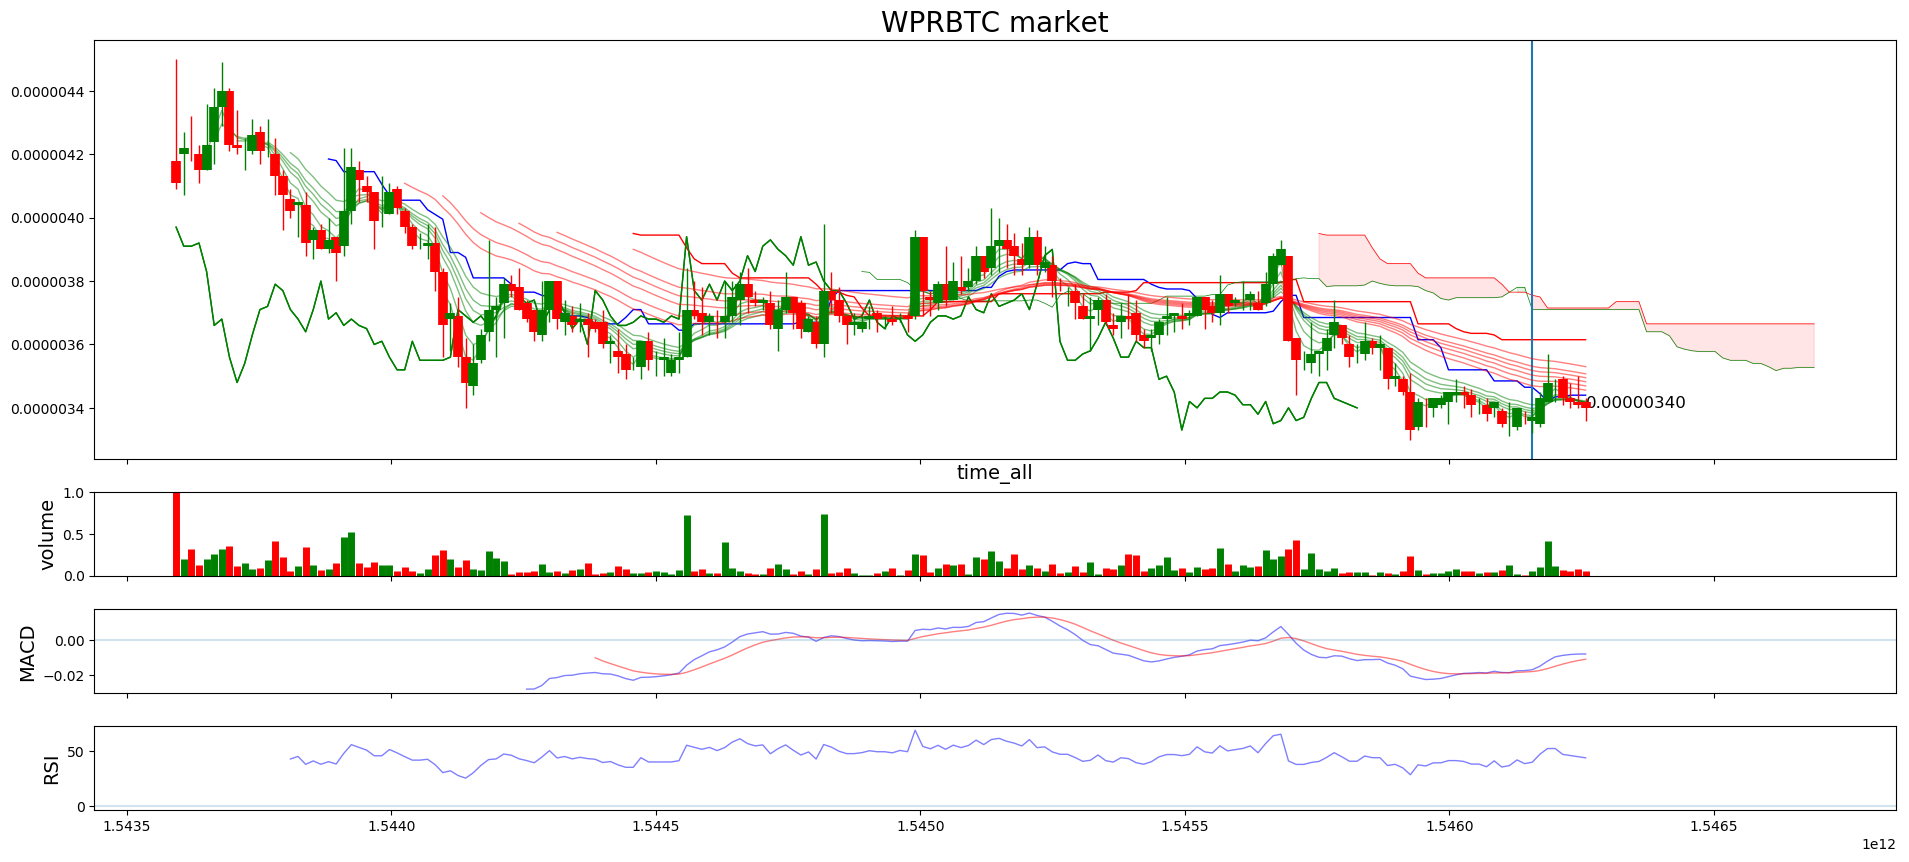

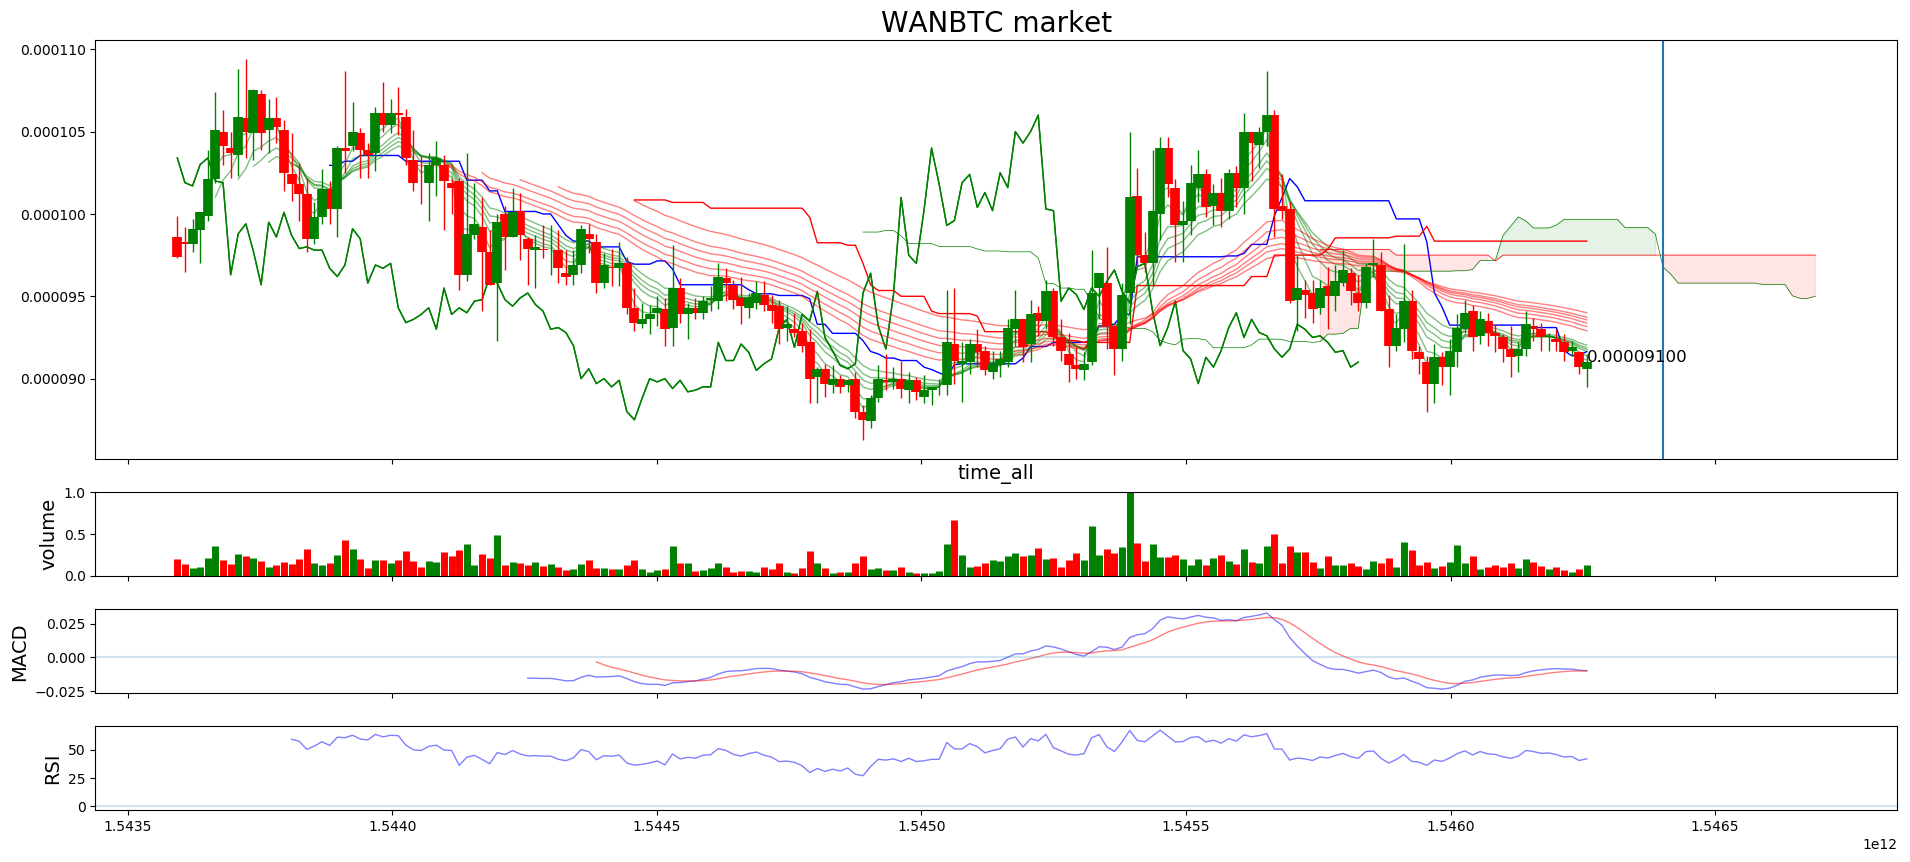

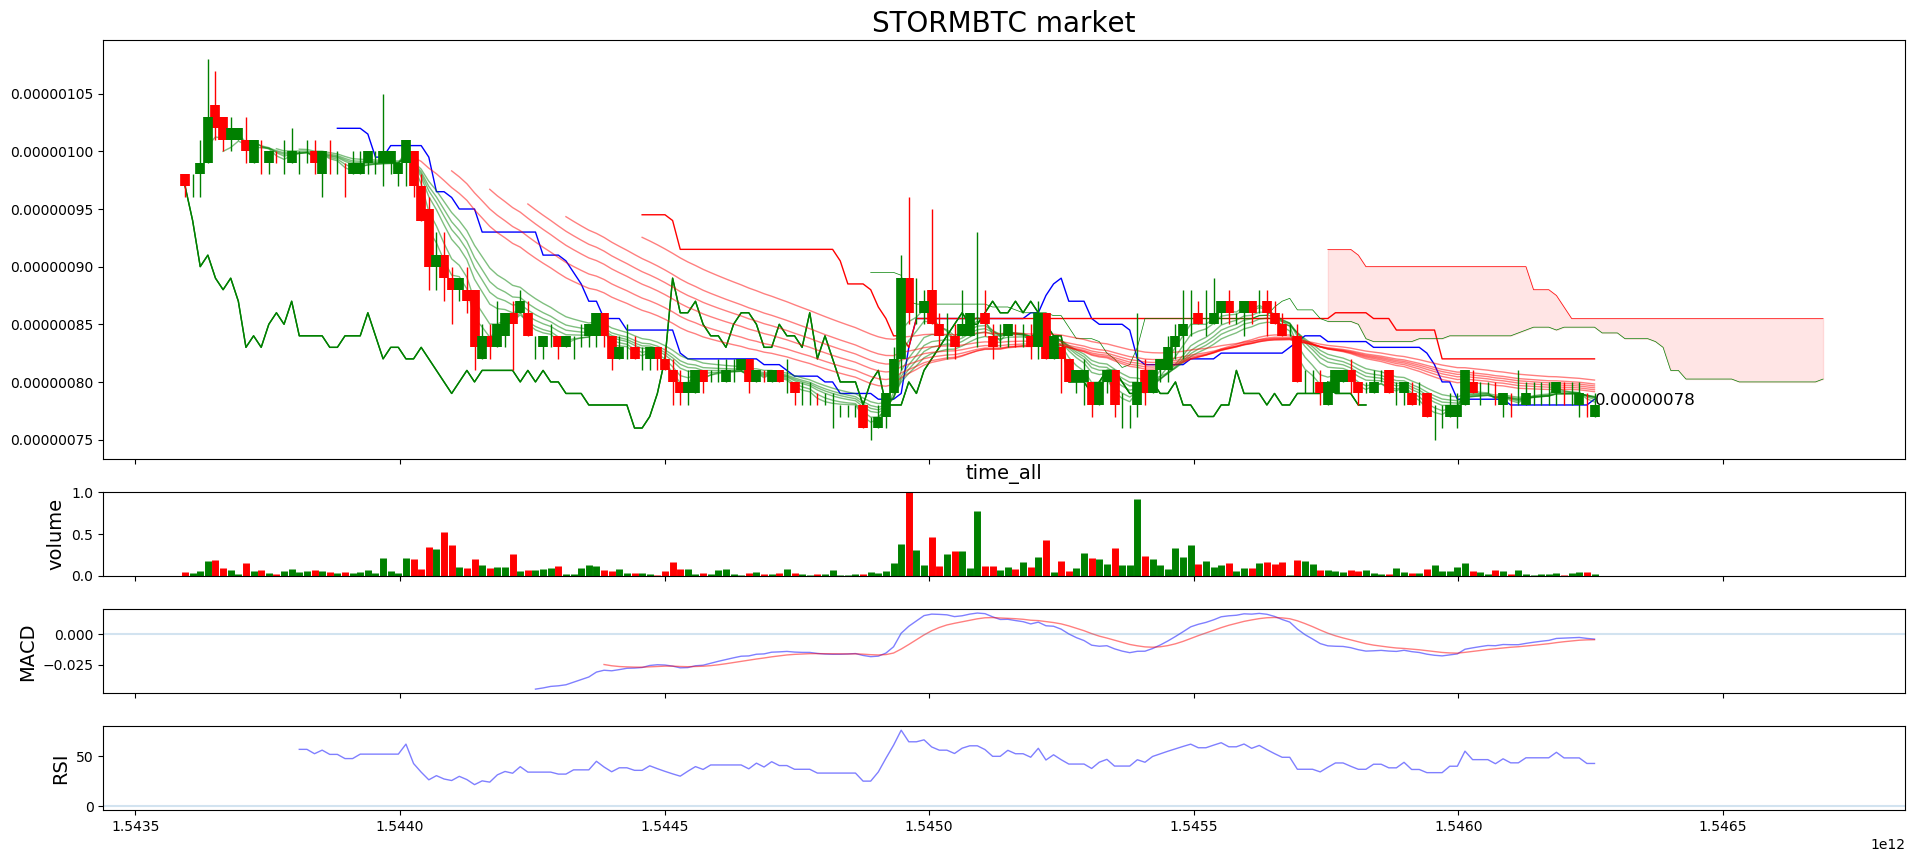

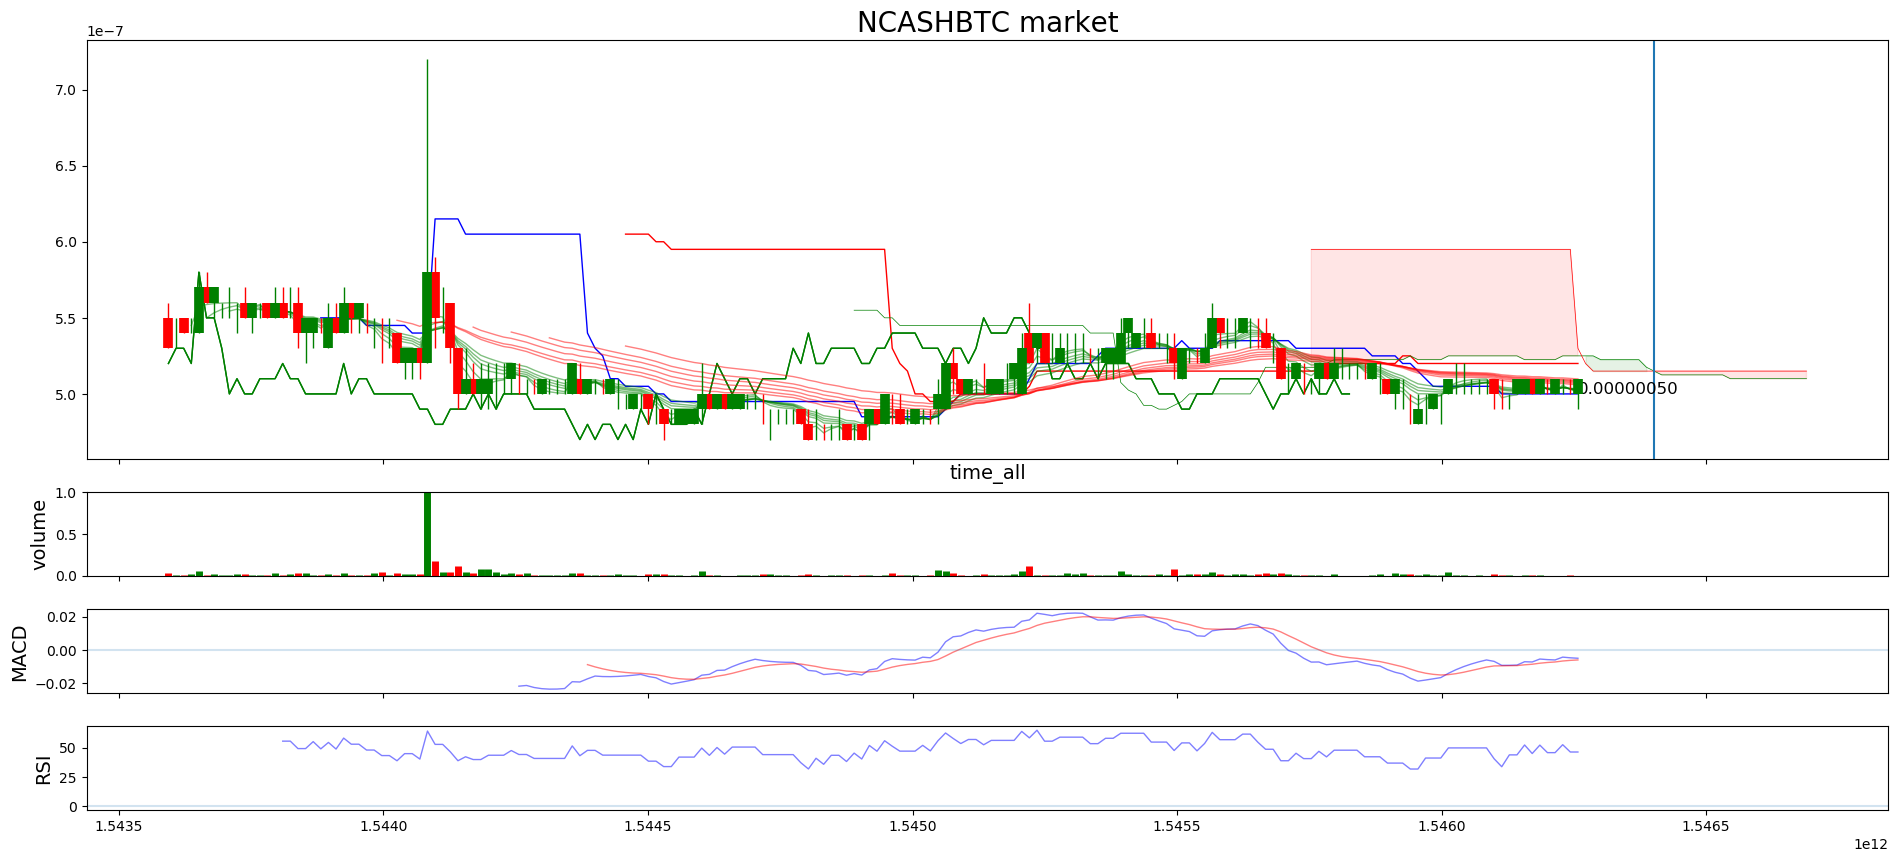

In [1]:
from IPython.core.display import Image, display
display(Image('data/img/WPRBTC_4H.png', width=1800, unconfined=True))
display(Image('data/img/WANBTC_4H.png', width=1800, unconfined=True))
display(Image('data/img/STORMBTC_4H.png', width=1800, unconfined=True))
display(Image('data/img/NCASHBTC_4H.png', width=1800, unconfined=True))

Part below regards the RNN LSTM model only. Everything else is put as code into other *.py files.

In [2]:
import psycopg2
from config import config
import numpy as np
import pandas as pd

/home/radek/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# Set the SQL params and connect to the server.
params = config()
conn = psycopg2.connect(**params)
cur = conn.cursor()

Because crypto is a fairly new market, I have chosen a 1Hour TimeFrame in order to get a lot of data.
Binance is a relatively new exchange (August 2017') - if I chose a 1Day TimeFrame, I would only get 
less than 500 entries.
The model I would create based on that small amount of data would not be satisfactory in any way.

Choosing 1H TimeFrame enabled me to get over 10000 entries.

In [4]:
# import data from SQL table - depending on the coin - its timeframe and datatable name will differ.
# data = pd.read_sql('SELECT * FROM btcusdt_1h', conn)

# Uncomment if you want to use a csv sample file instead (these should be in the data folder - choose one file)
# csv_path = 'data/btcusdt_1h.csv'
csv_path = 'data/neobtc_1h.csv'
data = pd.read_csv(csv_path, delimiter=';')

In [5]:
data = data.sort_values('open_time')
data.head()

,id,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote,no_trades,...,ema200,short_gmma,long_gmma,d_gmmas,senkou_a,senkou_b,d_senkou,macd,rsi,local_cloud
0,1,2017-07-22 14:00:00,0.002781,0.002794,0.002756,0.002786,8420.07,2017-07-22 14:59:00,23.398621,198,...,0.002620,0.000025,0.000027,0.000116,0.002712,0.002703,0.000009,1.198924,60.400567,0.013155
1,2,2017-07-22 15:00:00,0.002783,0.002829,0.002767,0.002810,8661.59,2017-07-22 15:59:00,24.193414,195,...,0.002622,0.000034,0.000028,0.000119,0.002724,0.002703,0.000021,1.341964,64.356953,0.013141
2,3,2017-07-22 16:00:00,0.002810,0.002849,0.002795,0.002849,9526.76,2017-07-22 16:59:00,26.844079,226,...,0.002624,0.000050,0.000031,0.000124,0.002732,0.002703,0.000029,1.525780,69.661432,0.013213
3,4,2017-07-22 17:00:00,0.002848,0.002937,0.002820,0.002905,14180.43,2017-07-22 17:59:00,40.573827,233,...,0.002627,0.000075,0.000035,0.000130,0.002737,0.002703,0.000034,1.714303,75.337134,0.014405
4,5,2017-07-22 18:00:00,0.002903,0.003197,0.002903,0.003148,12571.62,2017-07-22 18:59:00,38.083593,237,...,0.002632,0.000173,0.000046,0.000144,0.002781,0.002747,0.000034,2.187994,86.841092,0.014931


The SQL table is constructed to keep all of the indicators - these will be implemented in the RNN model in the future.

There are also some unnecessary columns that got imported from Binance exchange. These will not be useful for us. We will get rid of those right away.

In [6]:
data.drop(labels=['id', 'close_time', 'ignore_val', 'taker_quote'], inplace=True, axis=1)

The time we import from binance is in a timestamp form. 

I have written these two functions that allow us to change the timestamp into a UTC time format (or the other way around).

In [7]:
import time
from datetime import datetime, timezone

def to_timestamp(dt):
    timestamp = dt.replace(tzinfo=timezone.utc).timestamp()
    return timestamp

def time_from_ts(timestamp, timespec='minutes'):
    st = datetime.fromtimestamp(timestamp / 1000)
    time_transformed = str(st.isoformat(timespec=timespec, sep=' '))
    return time_transformed

For now, we will only be needing the coin price and we calculate it by the median of 'high_price' and 'low_price'.

In [8]:
data['mid_price'] = (data.high_price + data.low_price) / 2

In [9]:
data.head()

,open_time,open_price,high_price,low_price,close_price,volume,quote,no_trades,taker_base,ema12,...,short_gmma,long_gmma,d_gmmas,senkou_a,senkou_b,d_senkou,macd,rsi,local_cloud,mid_price
0,2017-07-22 14:00:00,0.002781,0.002794,0.002756,0.002786,8420.07,23.398621,198,5197.87,0.002756,...,0.000025,0.000027,0.000116,0.002712,0.002703,0.000009,1.198924,60.400567,0.013155,0.002775
1,2017-07-22 15:00:00,0.002783,0.002829,0.002767,0.002810,8661.59,24.193414,195,5896.77,0.002765,...,0.000034,0.000028,0.000119,0.002724,0.002703,0.000021,1.341964,64.356953,0.013141,0.002798
2,2017-07-22 16:00:00,0.002810,0.002849,0.002795,0.002849,9526.76,26.844079,226,5775.28,0.002778,...,0.000050,0.000031,0.000124,0.002732,0.002703,0.000029,1.525780,69.661432,0.013213,0.002822
3,2017-07-22 17:00:00,0.002848,0.002937,0.002820,0.002905,14180.43,40.573827,233,9692.48,0.002797,...,0.000075,0.000035,0.000130,0.002737,0.002703,0.000034,1.714303,75.337134,0.014405,0.002878
4,2017-07-22 18:00:00,0.002903,0.003197,0.002903,0.003148,12571.62,38.083593,237,7228.19,0.002851,...,0.000173,0.000046,0.000144,0.002781,0.002747,0.000034,2.187994,86.841092,0.014931,0.003050


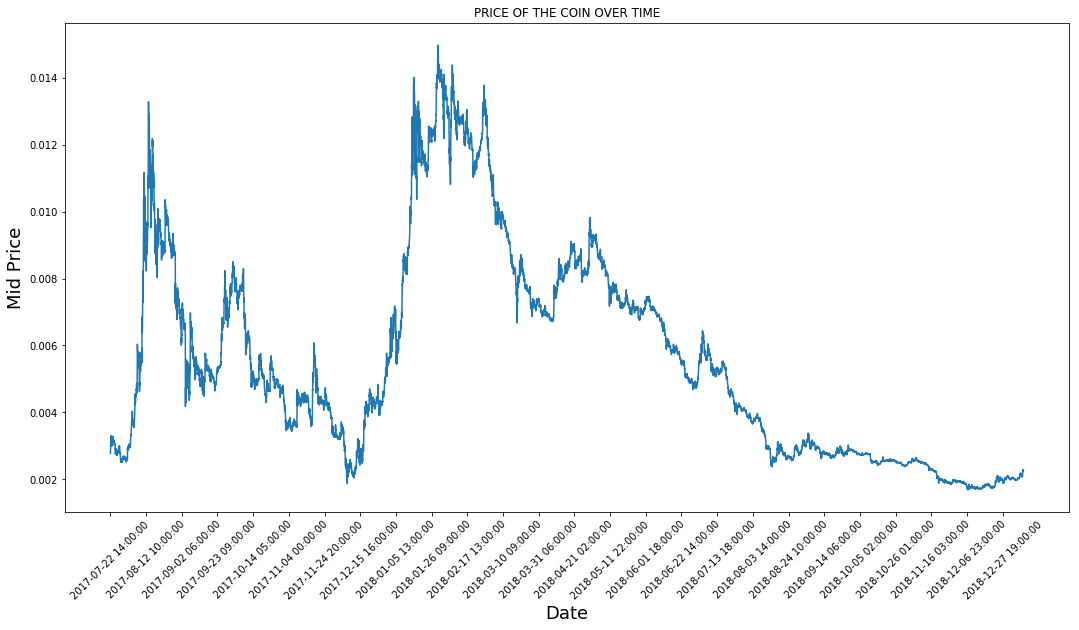

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),data['mid_price'])
plt.xticks(range(0,data.shape[0],500),data['open_time'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.title('PRICE OF THE COIN OVER TIME')
plt.show()

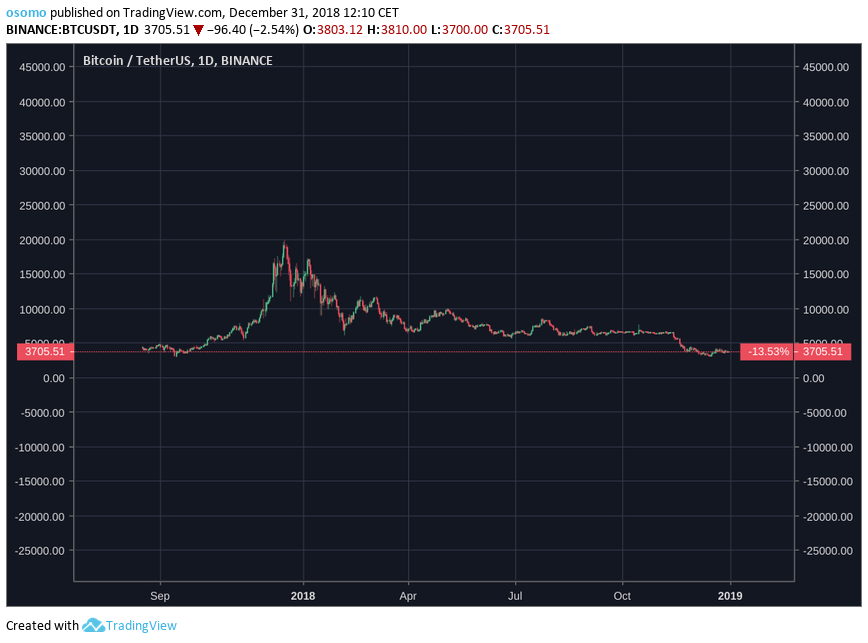

In [40]:
# Just to confirm, a screenshot from TradingView to confirm the data is correct.
# TradingView is the most known platform for technical analysis of the markets (not only crypto)
# The image might be obsolete - depending on the time you're reading it.
# It is a diagram for Bitcoin with 1D timeframe.
display(Image('data/img/btcusdt_1h.png', width=1200, unconfined=True))

In [12]:
# attaching data into a variable
mid_prices = data['mid_price']

# dividing the data into train/test
train_len = int(data.shape[0] * 0.8)
train_data = mid_prices[:train_len].values
test_data = mid_prices[train_len:].values

# reshaping the data
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [13]:
data.shape

(12791, 23)

In [14]:
train_data.shape

(10232, 1)

In [15]:
test_data.shape

(2559, 1)

In [16]:
# scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Because different time periods have different value ranges, I divide the data into smaller periods.
# In this case one window will be approximately 1/5th of the whole data length.

# Rounding the window size (to 100's) I will scale the data to.
round_size = int(train_data.shape[0]/100)*100
print(f'round size: {round_size}')
smoothing_window_size = int(round_size / 5)
print(smoothing_window_size)
    
for di in range(0, round_size, smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalizing the remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.fit_transform(test_data).reshape(-1)

round size: 10200
2040


Significant part of the code below was based on the Datacamps stock market tutorial - [LINK](https://www.datacamp.com/community/tutorials/lstm-python-stock-market)

It has been reviewed, fixed and redeveloped to match the crypto markets.

### I allow myself to quote [Investopedia]()
**Moving averages smooth the price data to form a trend following indicator. They do not predict price direction, but rather define the current direction with a lag. 
Moving averages lag because they are based on past prices. Despite this lag, moving averages help smooth price action and filter out the noise. 
They also form the building blocks for many other technical indicators and overlays, such as Bollinger Bands, MACD and the McClellan Oscillator. 
The two most popular types of moving averages are the Simple Moving Average (SMA) and the Exponential Moving Average (EMA). 
These moving averages can be used to identify the direction of the trend or define potential support and resistance levels.**

Using SMA, and EMA below to smooth up the diagrams - these in fact may predict the price, but they only use the past data average.

In [17]:
# Smoothing up with Exponential Moving Average - the price curve will be smoother.
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

The predictions below are conducted via averaging - SMA(simple moving average) and EMA (exponential moving average). 

Both of these work only when predicting one step ahead. Predicting more than one would produce bad results.

## SMA
What is Simple Moving Average - SMA
A simple moving average (SMA )is an arithmetic moving average calculated by adding recent closing prices 
and then dividing that by the number of time periods in the calculation average. A simple, or arithmetic, 
moving average that is calculated by adding the closing price of the security for a number of time periods 
and then dividing this total by that same number of periods. Short-term averages respond quickly to changes 
in the price of the underlying, while long-term averages are slow to react.

Source: https://www.investopedia.com/terms/s/sma.asp

In [18]:
window_size = 100
N = train_data.size
sma_predictions = []
sma_errors = []

for pred_idx in range(window_size,N):
    date = data.loc[pred_idx,'open_time']
    sma_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    # Comparing the prediction (mean value of last n-'window-sized' elements) to actual value
    sma_errors.append((sma_predictions[-1]-train_data[pred_idx])**2)

print(f'MSE error for SMA: {0.5*np.mean(sma_errors):.5f}')

MSE error for SMA: 0.00403


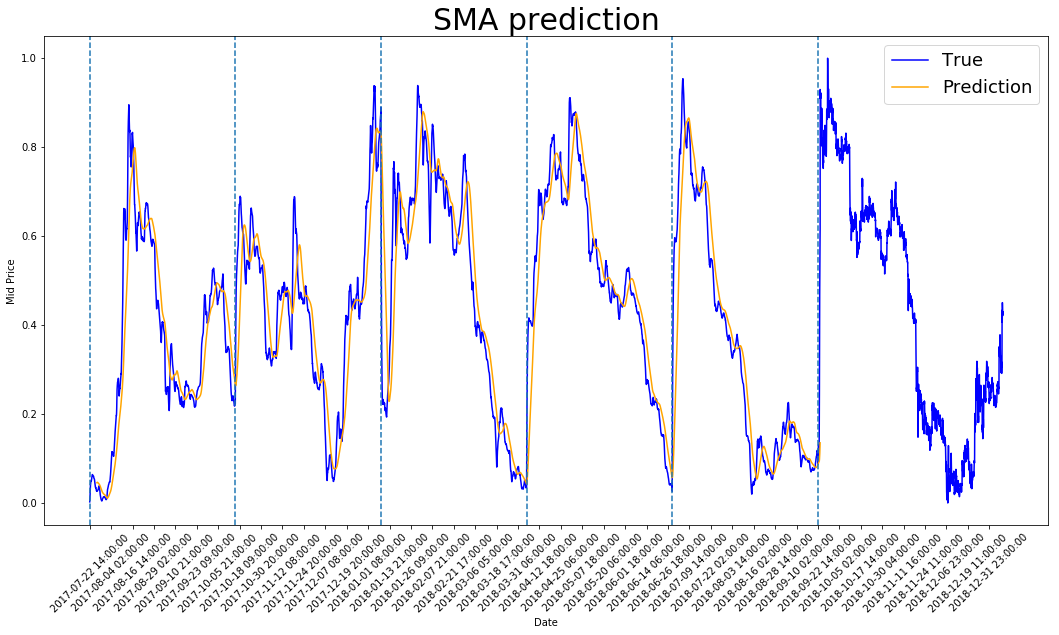

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),sma_predictions,color='orange',label='Prediction')
plt.xticks(range(0,data.shape[0],300),data['open_time'].loc[::300],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.title('SMA prediction', fontsize=30)
# Vlines showing the borders of scaling windows.
for di in range(0, round_size+smoothing_window_size, smoothing_window_size):
    plt.axvline(di, linestyle='--')
plt.show()

## EMA
What is Exponential Moving Average - EMA
An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period.

Source: https://www.investopedia.com/terms/e/ema.asp

In [20]:
ema_predictions = []
ema_errors = []
running_mean = sma_predictions[0]
multiplier = 2 / (window_size + 1)

ema_predictions.append(running_mean)
for pred_idx in range(window_size+1,N):
    running_mean = running_mean + multiplier*(train_data[pred_idx-1] - running_mean)
    ema_predictions.append(running_mean)
    ema_errors.append((ema_predictions[-1]-train_data[pred_idx])**2)

print(f'MSE error for EMA averaging: {0.5*np.mean(ema_errors):.5f}')

MSE error for EMA averaging: 0.00300


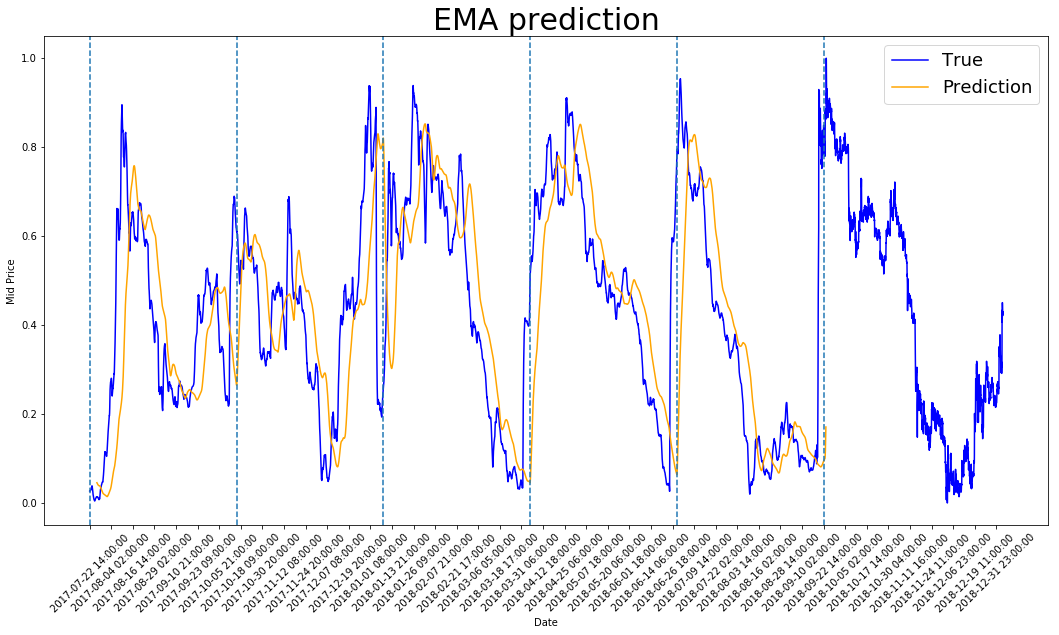

In [21]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]-window_size),all_mid_data[window_size:],color='b',label='True')
plt.plot(range(window_size,N),ema_predictions, color='orange', label='Prediction')
plt.xticks(range(0,data.shape[0],300),data['open_time'].loc[::300],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.title('EMA prediction', fontsize=30)
for di in range(0, round_size+smoothing_window_size, smoothing_window_size):
    plt.axvline(di, linestyle='--')
plt.show()

A significant amount of code below is based on the code from datacamp.com tutorial, which can be found here - [Link](https://www.datacamp.com/community/tutorials/lstm-python-stock-market). I have borrowed some of the code and fit it so that it would work with the Crypto Market.

In [22]:
class DataGeneratorSeq(object):
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

        
    def next_batch(self):
        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)
        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)
            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]
            self._cursor[b] = (self._cursor[b]+1)%self._prices_length
        return batch_data,batch_labels

    
    def unroll_batches(self):
        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):
            data, labels = self.next_batch()    
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels

    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [23]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00250522 0.38642102 0.33795503 0.35602555 0.5320716 ]

	Output: [0.0074173  0.45559466 0.28734162 0.37131634 0.5398436 ]


Unrolled index 1
	Inputs:  [0.00497332 0.40687883 0.31893575 0.36393952 0.5398436 ]

	Output: [0.0074173  0.425055   0.28734162 0.37777945 0.56575865]


Unrolled index 2
	Inputs:  [0.0074173  0.425055   0.30240873 0.37131634 0.5469738 ]

	Output: [0.01418385 0.45559466 0.2533873  0.38350827 0.5696207 ]


Unrolled index 3
	Inputs:  [0.01014113 0.44154564 0.28734162 0.37777945 0.5534525 ]

	Output: [0.01418385 0.4773334  0.2637045  0.3887131  0.560415  ]


Unrolled index 4
	Inputs:  [0.01418385 0.45559466 0.27461252 0.38350827 0.560415  ]

	Output: [0.01943213 0.4773334  0.2637045  0.40050787 0.5696207 ]


In [24]:
import tensorflow as tf

In [25]:
D = 1 # Dimensionality of the data (in this case - price)
num_unrollings = 50 # Number of timesteps looking into future
batch_size = 500 # Number of samples in one batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack
n_layers = len(num_nodes) # Number of layers

# There weren't significant differences between the dropouts 0.2, 0.4 and 0.6.
# The model works better with any of these, compared to no dropout.
dropout = 0.4 # dropout amount

tf.reset_default_graph() # Clearing the default graph stack

In [26]:
# Input data.
train_inputs, train_outputs = [],[]

# Generating train data placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name=f'train_inputs_{ui}'))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name =f'train_outputs_{ui}'))

In [27]:
# Defining LSTM cells in TF.
lstm_cells = [tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                                      state_is_tuple=True,
                                      initializer= tf.contrib.layers.xavier_initializer()
                                     )
              for li in range(n_layers)]

## Dropout

Originally motivated by the role of sex in evolution, dropout was proposed by Hinton et al. (2012), whereby a unit in a neural network is temporarily removed from a network. Srivastava et al. (2014) applied dropout to feed forward neural network’s and RBM’s and noted a probability of dropout around 0.5 for hidden units and 0.2 for inputs worked well for a variety of tasks.

[SOURCE](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b)

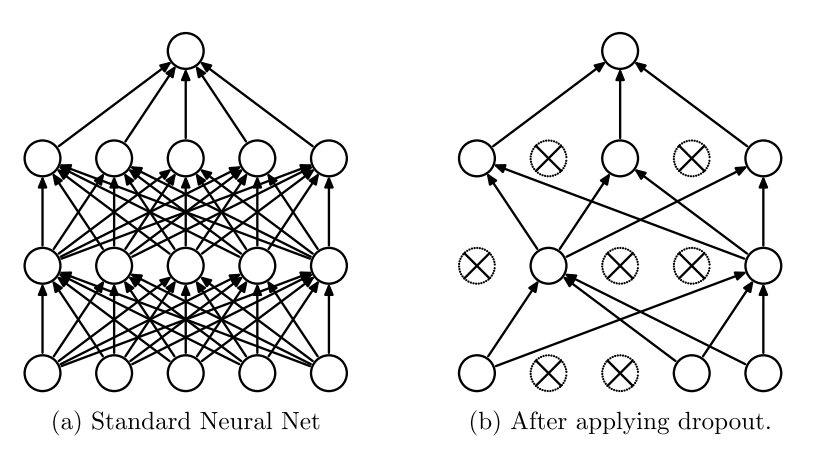

In [28]:
display(Image('data/img/dropout.png',unconfined=True))

In [29]:
# Implementing dropout cell. It is advised to use it as it greatly helps with overfitting.
# It also increases the performance.
drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(lstm, 
                                                 input_keep_prob=1.0,
                                                 output_keep_prob=1.0-dropout, 
                                                 state_keep_prob=1.0-dropout
                                                )
                   for lstm in lstm_cells
                  ]

# Stacking lstm-cells into Multi RNN Cell.
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

# Defining a regression layer.
w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [30]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

Doing several tensor transformations, because the function dynamic_rnn requires the output to be of
a specific format. Read more at: [LINK]( https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)

In [31]:
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

In [32]:
# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(drop_multi_cell, 
                                            all_inputs,
                                            initial_state=tuple(initial_state),
                                            time_major = True, 
                                            dtype=tf.float32
                                           )

all_lstm_outputs = tf.reshape(all_lstm_outputs, 
                              [batch_size*num_unrollings,num_nodes[-1]]
                             )

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

## Loss Calculation

In [33]:
# The loss is calculated for all of the unrolled steps at the same time.
# To calculate, a mean errors sum is calculated which then is divided by all unrolled steps.
print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(tf.train.exponential_decay(tf_learning_rate, 
                                                      global_step, 
                                                      decay_steps=1, 
                                                      decay_rate=0.5, 
                                                      staircase=True
                                                     ),
                           tf_min_learning_rate
                          )

Defining training Loss
Learning rate decay operations


 ## Optimizer

In [34]:
print('TF Optimization operations')
# Adam Optimizer was chosen. It is known for being effective.
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients, v))
print('\tAll done')

TF Optimization operations
	All done


In [35]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

# Calculating the prediction.
sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

# Outputting the result using a previously defined regression layer.
with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [36]:
# Test/Train sets lengths.
test_len = int(len(test_data)/50)*50
train_len = int(len(train_data) / 50) *50
test_len, train_len

(2550, 10200)

In [37]:
epochs = 30
valid_summary = 1 # Interval we make test predictions

n_predict_once = 50 # Number of steps we continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Train losses 
test_mse_ot = [] # Test losses
predictions_over_time = [] # Predictions

session = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0 

# If the test error hasn't increased in this many steps, decrease learning rate
loss_nondecrease_threshold = 2

average_loss = 0
print('Initialized')

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)
x_axis_seq = []

# Points we start the test predictions from
test_points_seq = np.arange(train_len, train_len+test_len, 50).tolist()

# Number of times the model will be learned for each epoch.
train_counts = train_seq_length//batch_size

for ep in range(epochs):       

    # ======== Training ============
    for step in range(train_counts):
        u_data, u_labels = data_gen.unroll_batches()
        feed_dict = {}
        
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l

    # ======== Validation ============
    if (ep+1) % valid_summary == 0:
        average_loss = average_loss/(valid_summary*(train_counts))

        # The average loss
        if (ep+1) % valid_summary == 0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)
        average_loss = 0 # reset loss
        predictions_seq = []
        mse_test_loss_seq = []

        # ======== Updating State and Making Predicitons ============
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary == 0:
                # Only calculate x_axis values in the first validation epoch
                x_axis=[]

            # Feed in the recent past behavior of prices
            # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1, w_i-1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                _ = session.run(sample_prediction, feed_dict=feed_dict)

            feed_dict = {}
            current_price = all_mid_data[w_i-1]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

            # Make predictions for this many steps
            # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):
                pred = session.run(sample_prediction, feed_dict=feed_dict)
                our_predictions.append(np.asscalar(pred))
                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary == 0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)
                    
                mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

            session.run(reset_sample_states)
            predictions_seq.append(np.array(our_predictions))
            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary == 0:
                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

        # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))

        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')


Initialized
Average loss at step 1: 1.553429
	Test MSE: 0.02535
	Finished Predictions
Average loss at step 2: 0.242307
	Test MSE: 0.00771
	Finished Predictions
Average loss at step 3: 0.136052
	Test MSE: 0.00389
	Finished Predictions
Average loss at step 4: 0.107289
	Test MSE: 0.00353
	Finished Predictions
Average loss at step 5: 0.091461
	Test MSE: 0.00331
	Finished Predictions
Average loss at step 6: 0.083198
	Test MSE: 0.00333
	Finished Predictions
Average loss at step 7: 0.075975
	Test MSE: 0.00332
	Finished Predictions
Average loss at step 8: 0.074247
	Test MSE: 0.00330
	Finished Predictions
Average loss at step 9: 0.066562
	Test MSE: 0.00330
	Finished Predictions
Average loss at step 10: 0.068600
	Test MSE: 0.00332
	Finished Predictions
Average loss at step 11: 0.069079
	Test MSE: 0.00329
	Finished Predictions
Average loss at step 12: 0.068582
	Test MSE: 0.00344
	Finished Predictions
Average loss at step 13: 0.065227
	Test MSE: 0.00331
	Finished Predictions
Average loss at step 1

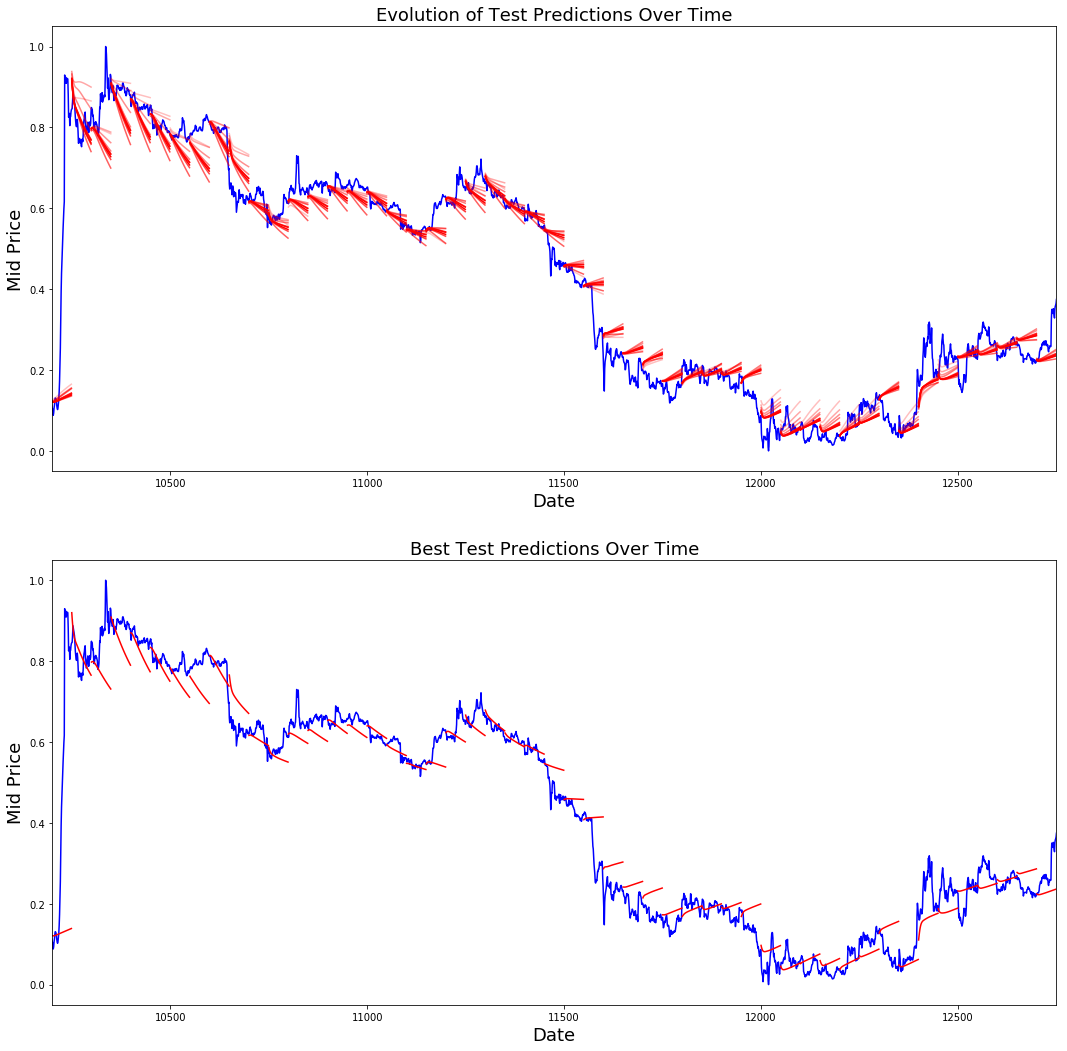

In [38]:
# Best epoch might differ each time the learning process is due.
best_prediction_epoch = 27
plt.figure(figsize = (18,18))

plt.subplot(2,1,1)
plt.plot(range(data.shape[0]),all_mid_data,color='b')
# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha, 1.1, (1.0-start_alpha)/len(predictions_over_time[::4]))
for p_i,p in enumerate(predictions_over_time[4::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])
plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(train_len,train_len+test_len)

plt.subplot(2,1,2)
# Predicting the best test prediction you got
plt.plot(range(data.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(train_len,train_len+test_len)
plt.show()

## Conclusion

The predictions for the crypto market are tricky. The amount of unpredictable price movements in it is enormous. It is known, that the markets are being manipulated by 'whales', thus it very hard, nearly impossible, to properly predict such movements. In the current notebook, I have shown, that even though, the predictions weren't accurate, an overall trend, telling us whether the price will go up or down, was plenty of times preserved.
These predictions though, should be taken with a grain of salt. You should not rely on them in the real world.

The amount of data I used for learning purposes is still small. Surely, it would be way better if there were more data.
In the current project, the learning rate was decayed basing on a loss on the test-set. This should not happen, as it means that some of the data has been leaked. 
A proper way would be to have an additional validation set on which we could base the learning rate's decay.

Effectiveness of the LSTM model would be much higher, if only the hyperparameters of it were chosen through a GridSearch. Possible hyperparams are: number of layers, number of hidden units in each layer, learning rate of optimizer. Also, a different optimizer could be used.



## References
* [https://www.tensorflow.org/tutorials/sequences/recurrent](https://www.tensorflow.org/tutorials/sequences/recurrent)
* [https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction](https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction)
* [http://colah.github.io/posts/2015-08-Understanding-LSTMs/](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [https://www.investopedia.com/](https://www.investopedia.com/)
* [https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md](https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md)
* [https://www.postgresql.org/docs/](https://www.postgresql.org/docs/)
* 'Uczenie maszynowe z uzyciem Tensorflow' - wydawnictwa O'Reilly


